In [ ]:
import os
import act
import xarray as xr
import glob
import pandas as pd
from sublimpy import utils

In [ ]:
start_date = '20221101'
end_date = '20230619'
data_start_date = '20221130'
data_cutoff_date = '20230508'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane_flaggeddataremains.parquet"
# slope relative local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit.parquet"
# seemingly local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

splash_download_dir = '/Users/elischwat/Development/data/sublimationofsnow/'

# Open data

## SOS

In [ ]:
tidy_df = pd.read_parquet('../paper1/' + sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds

tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

In [ ]:
src = tidy_df.query(f"variable == 'dir_3m_c'")['value'].dropna()
pd.cut(
    src,
    [0,80, 140, 292,332, 360]
).value_counts() / len(src)

# SAIL data

In [ ]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
rad_gothic = 'gucgndrad60sM1.b1'
irt_gothic = 'gucgndirtM1.b1'
sebs_kp = 'gucsebsS3.b1'

## Download ECOR and MET data

In [ ]:
gothic_sail_ecor_download_dir = os.path.join(splash_download_dir, ecor_gothic)

gothic_sail_met_download_dir = os.path.join(splash_download_dir, met_gothic)

In [ ]:
act.discovery.download_arm_data(
    username,    token,    ecor_gothic,    
    start_date,
    end_date,
    output = gothic_sail_ecor_download_dir
)

In [ ]:
act.discovery.download_arm_data(
    username,    token,    met_gothic,    
    start_date,
    end_date,
    output = gothic_sail_met_download_dir
)

## Download SEBS data

In [ ]:
kp_sail_sebs_download_dir = os.path.join(splash_download_dir, sebs_kp)
kp_sail_sebs_download_dir

In [ ]:
act.discovery.download_arm_data(
    username,    token,    sebs_kp,    
    start_date,
    end_date,
    output = kp_sail_sebs_download_dir
)

## Download radiation data

In [ ]:
gothic_sail_rad_download_dir = os.path.join(splash_download_dir, rad_gothic)
gothic_sail_rad_download_dir

In [ ]:
act.discovery.download_arm_data(
    username,    token,    rad_gothic,    
    start_date,
    end_date,
    output = gothic_sail_rad_download_dir
)

## Download the infrared thermometer measurements

In [ ]:
gothic_sail_irt_download_dir = os.path.join(splash_download_dir, irt_gothic)
gothic_sail_irt_download_dir

In [ ]:
act.discovery.download_arm_data(
    username,    token,    irt_gothic,    
    start_date,
    end_date,
    output = gothic_sail_irt_download_dir
)

## Open it all

In [48]:
sebs_kp_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(splash_download_dir, sebs_kp, '*.cdf'))
).sel(time = slice("2023-02-01", "2023-02-08"))
irt_gothic_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(splash_download_dir, irt_gothic, '*.nc'))
).sel(time = slice("2023-02-01", "2023-02-08"))
rad_gothic_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(splash_download_dir, rad_gothic, '*.cdf'))
).sel(time = slice("2023-02-01", "2023-02-08"))
ecor_gothic_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(splash_download_dir, ecor_gothic, '*.cdf'))
).sel(time = slice("2023-02-01", "2023-02-08"))
met_gothic_ds = act.io.read_arm_netcdf(
    glob.glob(os.path.join(splash_download_dir, met_gothic, '*.cdf'))
).sel(time = slice("2023-02-01", "2023-02-08"))

In [49]:
print(sebs_kp_ds.lat.values[0], sebs_kp_ds.lon.values[0])
print(irt_gothic_ds.lat.values[0], irt_gothic_ds.lon.values[0])
print(rad_gothic_ds.lat.values[0], rad_gothic_ds.lon.values[0])
print(ecor_gothic_ds.lat.values[0], ecor_gothic_ds.lon.values[0])
print(met_gothic_ds.lat.values[0], met_gothic_ds.lon.values[0])

38.941555 -106.97313
38.956158 -106.987854
38.956158 -106.987854
38.956158 -106.987854
38.956158 -106.987854


In [52]:

from sublimpy import utils 

In [53]:
sebs_kp_ds = utils.modify_xarray_timezone(sebs_kp_ds, "UTC", "US/Mountain")
irt_gothic_ds = utils.modify_xarray_timezone(irt_gothic_ds, "UTC", "US/Mountain")
rad_gothic_ds = utils.modify_xarray_timezone(rad_gothic_ds, "UTC", "US/Mountain")

In [54]:
STEVEN_BOLTZMAN = 5.67e-08 #W/m^2/degK^4
SNOW_EMMISIVITY = 0.98 

In [55]:


sebs_kp_ds['sfc_ir_temp'] = (
    (
        sebs_kp_ds['up_long'] + STEVEN_BOLTZMAN * (sebs_kp_ds['temp_net_radiometer']+273.15)**4
    ) / (SNOW_EMMISIVITY*STEVEN_BOLTZMAN)
)**(1/4) - 273.15

rad_gothic_ds['sfc_ir_temp'] = (
    (
        rad_gothic_ds['up_long_hemisp'] + STEVEN_BOLTZMAN * (rad_gothic_ds['inst_up_long_hemisp_case_temp'])**4
    ) / (SNOW_EMMISIVITY*STEVEN_BOLTZMAN)
)**(1/4) - 273.15

irt_gothic_ds['sfc_ir_temp'] = irt_gothic_ds['sfc_ir_temp']-273.15

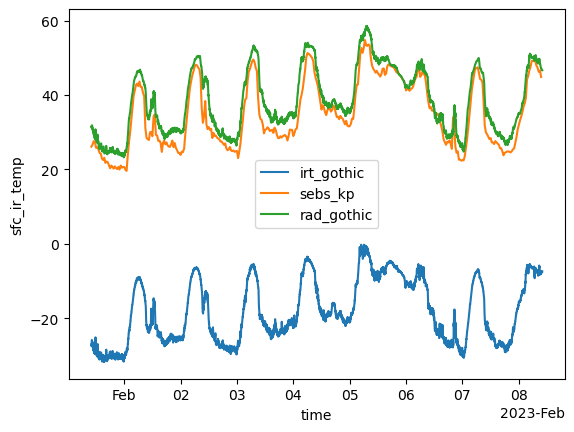

In [56]:
import matplotlib.pyplot as plt
irt_gothic_ds['sfc_ir_temp'].plot(label='irt_gothic')
sebs_kp_ds['sfc_ir_temp'].plot(label='sebs_kp')
rad_gothic_ds['sfc_ir_temp'].plot(label='rad_gothic')
plt.legend()

In [59]:
src = tidy_df.set_index("time").loc["2023-02-01": "2023-02-08"]
src = src[src.variable.isin(['Tsurf_rad_d', 'Tsurf_c'])]


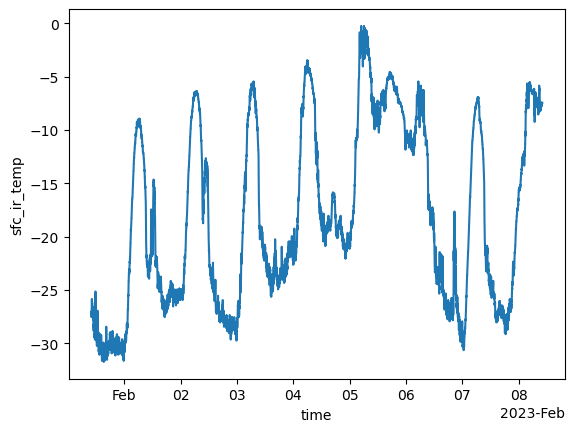

In [60]:
irt_gothic_ds['sfc_ir_temp'].plot(label='SAIL irt Gothic')

In [61]:
src = src.query("variable == 'Tsurf_rad_d'")[['value']].rename(columns={'value': 'Tsurf_rad_d'}).merge(
    src.query("variable == 'Tsurf_c'")[['value']].rename(columns={'value': 'Tsurf_c'}),
    on = 'time'
).merge(
    irt_gothic_ds['sfc_ir_temp'].resample(time='30Min').mean().to_dataframe(),
    on = 'time'
)

In [62]:
import altair as alt

In [63]:
alt.Chart(src.reset_index()).transform_fold(
    ['Tsurf_rad_d', 'Tsurf_c', 'sfc_ir_temp']
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('Surface temperature (˚C)'),
    alt.Color("key:N").title("sensor")
).properties(width = 600).display(renderer='svg')

alt.Chart(...)

# Examine times with above-freezing temps

In [79]:
alt.data_transformers.enable('json')
alt.renderers.enable('html')

RendererRegistry.enable('html')

In [104]:
alt.Chart(
    tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])]
).transform_calculate(
    is_above_freezing = 'datum.value > 0'
).mark_line().encode(
    alt.X('time:T'),
    # alt.Y('value:Q'),
    alt.Y('value:Q', impute=alt.ImputeParams(value=None)).title('Surface temperature (˚C)'),
    alt.Color('is_above_freezing:N'),
    alt.Detail('variable:N'),
).properties(width=600, height = 200)

alt.Chart(...)

In [105]:
casestudy1 = ('20230311', '20230316')
casestudy2 = ('20230407', '20230414')
casestudy3 = ('20230501', '20230505')

In [151]:
tsurf_plots = alt.Chart(
    tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])][
        (tidy_df.time > casestudy1[0]) & (tidy_df.time < casestudy1[1])
    ]
).transform_calculate(
    is_above_freezing = 'datum.value > 0'
).mark_line(strokeWidth=1).encode(
    alt.X('time:T').axis(format='%m/%d %H00', labelAngle=-22.5).title(None),
    # alt.Y('value:Q'),
    alt.Y('value:Q', impute=alt.ImputeParams(value=None)).title('Surface temperature (˚C)').scale(domain=[-15,2], clamp=True),
    alt.Color('variable:N')
).properties(width=250, height = 150) &\
alt.Chart(
    tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])][
        (tidy_df.time > casestudy2[0]) & (tidy_df.time < casestudy2[1])
    ]
).transform_calculate(
    is_above_freezing = 'datum.value > 0'
).mark_line(strokeWidth=1).encode(
    alt.X('time:T').axis(format='%m/%d %H00', labelAngle=-22.5).title(None),
    # alt.Y('value:Q'),
    alt.Y('value:Q', impute=alt.ImputeParams(value=None)).title('Surface temperature (˚C)').scale(domain=[-15,2], clamp=True),
    alt.Color('variable:N')
).properties(width=250, height = 150)  &\
alt.Chart(
    tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])][
        (tidy_df.time > casestudy3[0]) & (tidy_df.time < casestudy3[1])
    ]
).transform_calculate(
    is_above_freezing = 'datum.value > 0'
).mark_line(strokeWidth=1).encode(
    alt.X('time:T').axis(format='%m/%d %H00', labelAngle=-22.5).title(None),
    # alt.Y('value:Q'),
    alt.Y('value:Q', impute=alt.ImputeParams(value=None)).title('Surface temperature (˚C)').scale(domain=[-15,2], clamp=True),
    alt.Color('variable:N')
).properties(width=250, height = 150) 
tsurf_plots

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_28723/2614683076.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])][
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_28723/2614683076.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])][
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_28723/2614683076.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.variable.isin(['Tsurf_uw', 'Tsurf_c', 'Tsurf_d', 'Tsurf_ue'])][


alt.VConcatChart(...)

In [153]:
near_surface_thermistor_df = tidy_df.query(
    "measurement == 'snow temperature'"
).query(
    "tower == 'd'").set_index('time'
).join(
    tidy_df.query("variable == 'SnowDepth_d'").set_index('time')['value'].rename('SnowDepth_d')
)
near_surface_thermistor_df['height_to_surface'] = near_surface_thermistor_df['height'] - near_surface_thermistor_df['SnowDepth_d']
near_surface_thermistor_df = near_surface_thermistor_df.reset_index()
def plot(src):
    return alt.Chart(src).mark_line(strokeWidth=1.5).encode(
        alt.X('time:T'),
        alt.Y('height_to_surface'),
        alt.Color('variable:O')
    ).properties(height = 150)
near_surface_thermistor_height_plot = (plot(near_surface_thermistor_df[
            (near_surface_thermistor_df.time > casestudy1[0]) 
            & (near_surface_thermistor_df.time < casestudy1[1])
        ]) &\
plot(near_surface_thermistor_df[
            (near_surface_thermistor_df.time > casestudy2[0]) 
            & (near_surface_thermistor_df.time < casestudy2[1])
        ]) &\
plot(near_surface_thermistor_df[
            (near_surface_thermistor_df.time > casestudy3[0]) 
            & (near_surface_thermistor_df.time < casestudy3[1])
        ]))
near_surface_thermistor_height_plot

alt.VConcatChart(...)

In [154]:
def plot(src):
    return alt.Chart(src).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q'),
        alt.Color('variable:O').scale(scheme='turbo')
    ).properties(height=150)
near_surface_thermistor_plot = (plot(
    near_surface_thermistor_df[
                (near_surface_thermistor_df.time > casestudy1[0]) 
                & (near_surface_thermistor_df.time < casestudy1[1])
    ][
        near_surface_thermistor_df.variable.isin(['Tsnow_1_4m_d', 'Tsnow_1_5m_d'])
    ]
) & plot(
    near_surface_thermistor_df[
                (near_surface_thermistor_df.time > casestudy2[0]) 
                & (near_surface_thermistor_df.time < casestudy2[1])
    ][
        near_surface_thermistor_df.variable.isin(['Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d'])
    ]
) & plot(
    near_surface_thermistor_df[
                (near_surface_thermistor_df.time > casestudy3[0]) 
                & (near_surface_thermistor_df.time < casestudy3[1])
    ][
        near_surface_thermistor_df.variable.isin(['Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d'])
    ]
)).resolve_scale(color='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_28723/2238044288.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  near_surface_thermistor_df[
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_28723/2238044288.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  near_surface_thermistor_df[
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_28723/2238044288.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  near_surface_thermistor_df[


In [155]:
near_surface_thermistor_height_plot | near_surface_thermistor_plot

alt.HConcatChart(...)